In [2]:
import jcopdl
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [31]:
jcopdl.__version__

'1.1.1'

# Dataset & Dataloader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from jcopdl.utils.dataloader import MultilabelDataset

bs = 64
crop_size = 224 

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224), # ikuti model mobilenet v2
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # mengikuti aturan model mobile net v2
])

train_set = MultilabelDataset("data/data/train_label.csv", "data/data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data/data/test_label.csv", "data/data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [4]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitektur & Config

## Contoh cara pakai pretrained-model

In [5]:
from torchvision.models import mobilenet_v2

In [ ]:
mnet = mobilenet_v2(weights=True)

# membekukan weight dari model mobilenet v2
for param in mnet.parameters():
    param.requires_grad = False

c:\Users\akmal\anaconda3\envs\jcopdl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [10]:
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

In [ ]:
# menimpa layer terakhir dari model mobilevnet2 menyesuaikan dengan label kita
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [12]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [15]:
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(weights=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True
        

In [16]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

## Phase 1: Adaptation (lr standard + patience kecil)

In [17]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2 ,outdir="model")

c:\Users\akmal\anaconda3\envs\jcopdl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode =="train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()

    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [ ]:
while True:
    train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)

    with torch.no_grad():
        test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break

        

## Phase 2: Fine-tuning (lr dikecilin, patience ditambah)

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

In [ ]:
while True:
    train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)

    with torch.no_grad():
        test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break

        

# Predict

In [25]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [26]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float)
preds

tensor([[1., 1., 1., 1., 0.],
        [1., 0., 0., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1.],
        [1., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [1., 0., 0., 1., 0.],
        [1., 0., 1., 1., 1.],
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1.],
        [0

# Sanity Check

In [23]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred == 1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] = 0.229 + 0.485
    img[1, :, :] = img[1, :, :] = 0.224 + 0.456
    img[2, :, :] = img[2, :, :] = 0.225 + 0.406
    return img

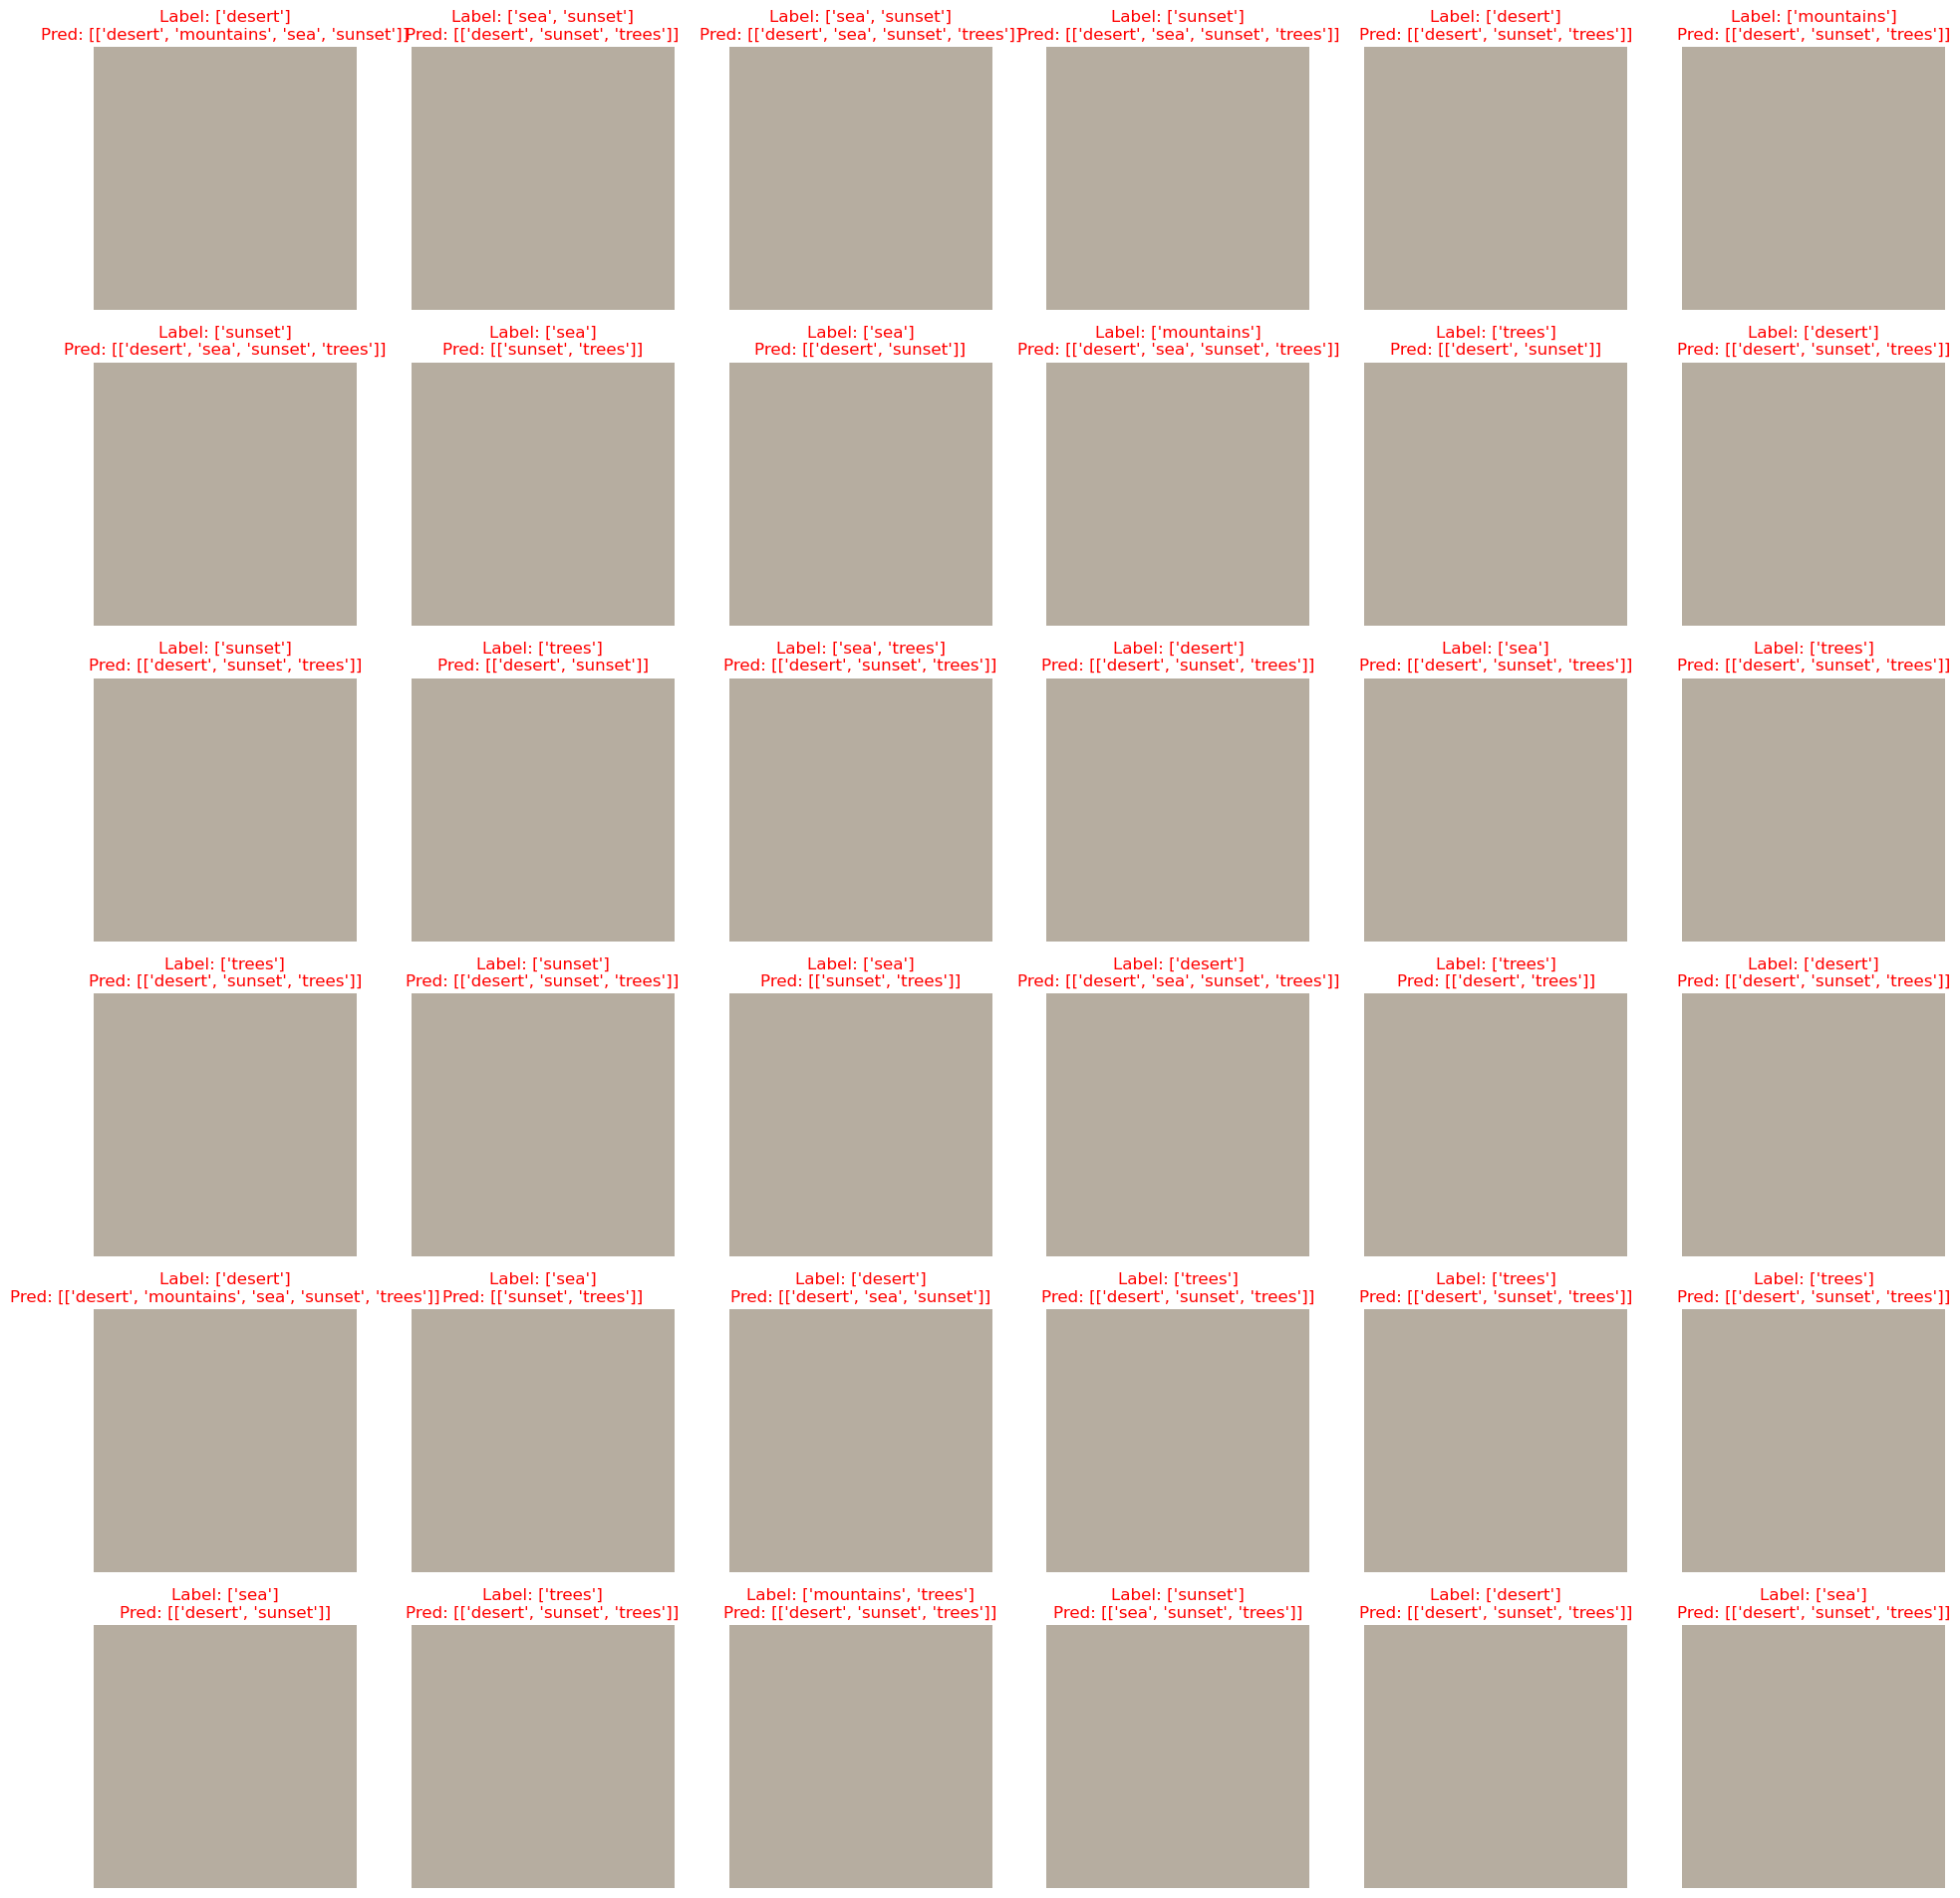

In [28]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color": "r"} if (pred != label).any() else {"color": "g"}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"Label: {label}\nPred: {[pred]}", fontdict=font);
    ax.axis('off');


In [29]:
img

tensor([[[0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140],
         [0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140],
         [0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140],
         ...,
         [0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140],
         [0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140],
         [0.7140, 0.7140, 0.7140,  ..., 0.7140, 0.7140, 0.7140]],

        [[0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800],
         [0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800],
         [0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800],
         ...,
         [0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800],
         [0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800],
         [0.6800, 0.6800, 0.6800,  ..., 0.6800, 0.6800, 0.6800]],

        [[0.6310, 0.6310, 0.6310,  ..., 0.6310, 0.6310, 0.6310],
         [0.6310, 0.6310, 0.6310,  ..., 0.6310, 0.6310, 0.6310],
         [0.6310, 0.6310, 0.6310,  ..., 0.6310, 0.6310, 0.